<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/others/techgig_datascience_raisin/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [53]:
import gc
import os
import warnings
import subprocess

gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [54]:
SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [55]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/others/techgig_datascience_raisin/data'

train = pd.read_csv(f'{DATA_URL}/raw/train.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test.csv')
sample_sub = pd.read_csv(f'{DATA_URL}/raw/sample_sub.csv')

# Data overview

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Key              495 non-null    int64  
 1   Area             495 non-null    int64  
 2   MajorAxisLength  495 non-null    float64
 3   MinorAxisLength  495 non-null    float64
 4   Eccentricity     495 non-null    float64
 5   ConvexArea       495 non-null    int64  
 6   Extent           495 non-null    float64
 7   Perimeter        495 non-null    float64
 8   Class            495 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 34.9+ KB


In [57]:
train.head()

,Key,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,1,87524,442.2460,253.2912,0.8197,90546,0.7587,1184.040,Keci
1,2,75166,406.6907,243.0324,0.8018,78789,0.6841,1121.786,Keci
2,3,90856,442.2670,266.3283,0.7984,93717,0.6376,1208.575,Keci
3,4,45928,286.5406,208.7600,0.6850,47336,0.6996,844.162,Keci
4,5,79408,352.1908,290.8275,0.5640,81463,0.7928,1073.251,Keci


In [58]:
sample_sub.head()

,Key,Class
0,1,Keci
1,2,Bes
2,3,Keci
3,4,Bes
4,5,Bes


In [59]:
train.shape, test.shape, sample_sub.shape

((495, 9), (405, 8), (14, 2))

In [60]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

In [61]:
TEST_INDEX = test['Key']

# Target

In [62]:
TARGET = 'Class'

In [63]:
train[TARGET].value_counts(normalize=True)

Bes     0.501
Keci    0.499
Name: Class, dtype: float64

Perfectly balanced.

In [64]:
label_enc = LabelEncoder()
train[TARGET] = label_enc.fit_transform(train[TARGET])

In [65]:
train[TARGET].value_counts(normalize=True)

0    0.501
1    0.499
Name: Class, dtype: float64

# Features

In [66]:
features = [f for f in test.columns if f != 'Key']

### Utility functions for visualization

In [67]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    fig.tight_layout()
    plt.show()

In [68]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

### Area

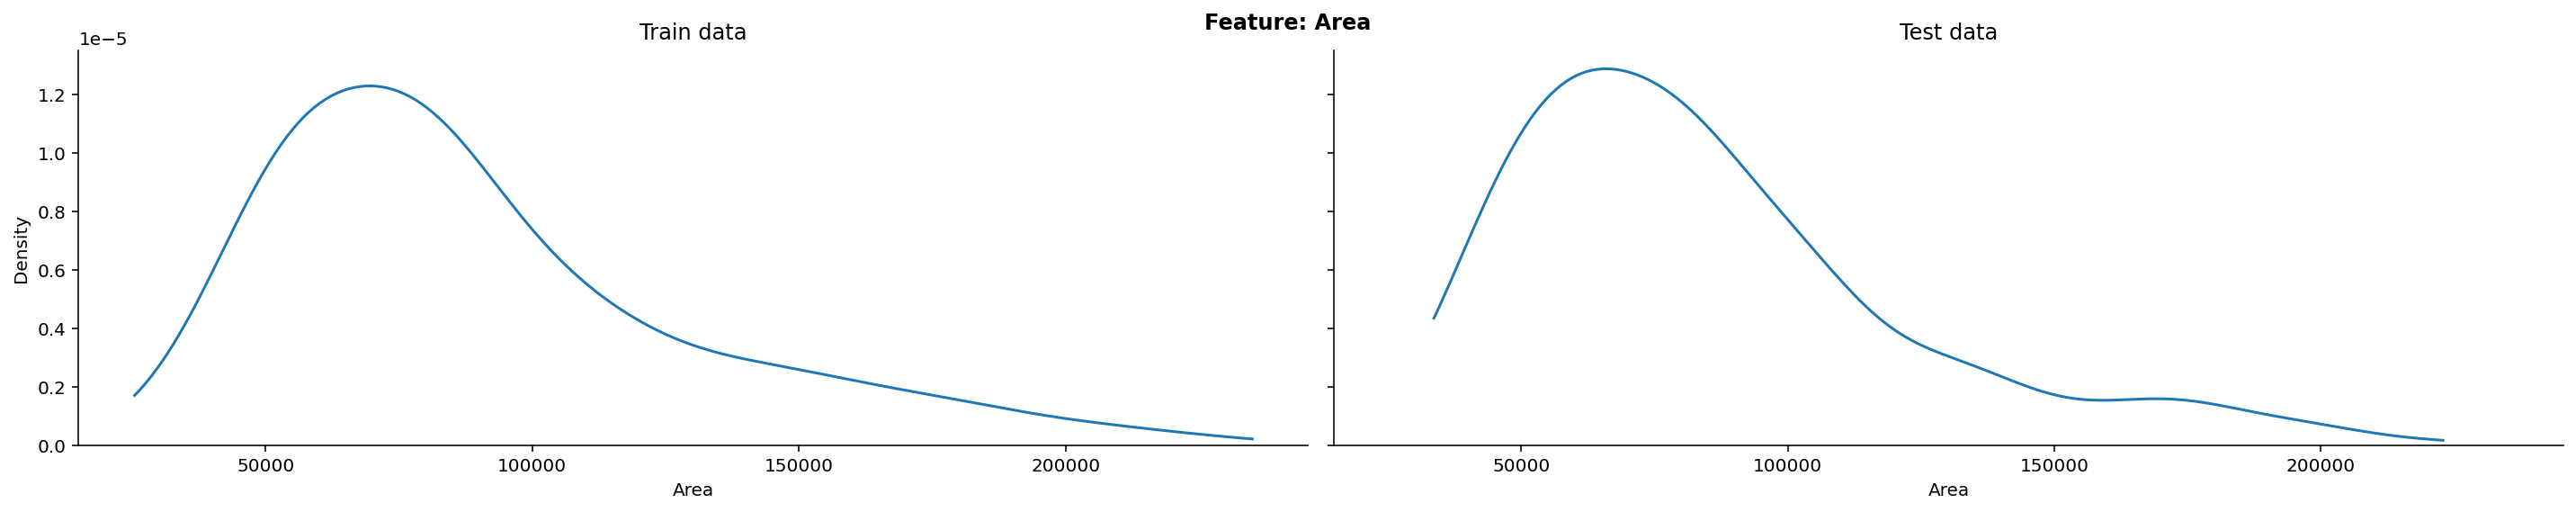

In [69]:
plot_cont('Area')

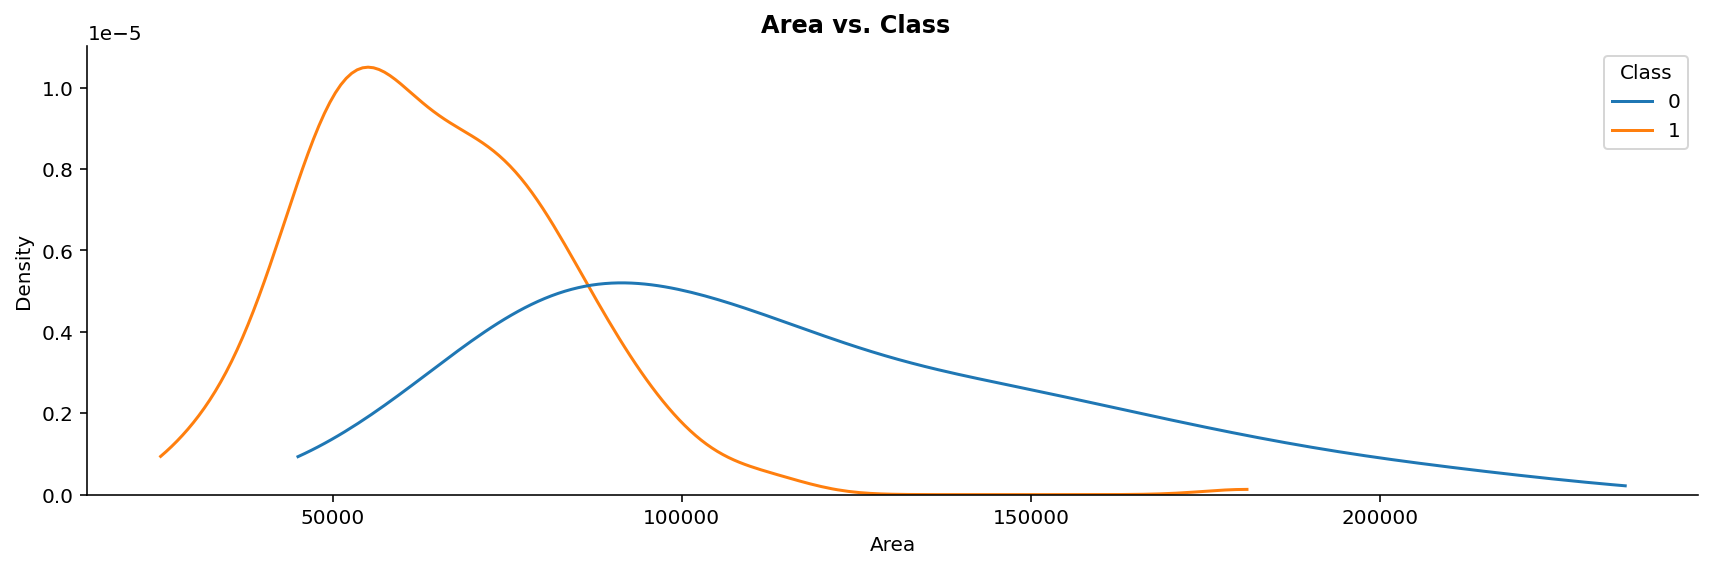

In [70]:
plot_cont_vs_target('Area')

### Perimeter

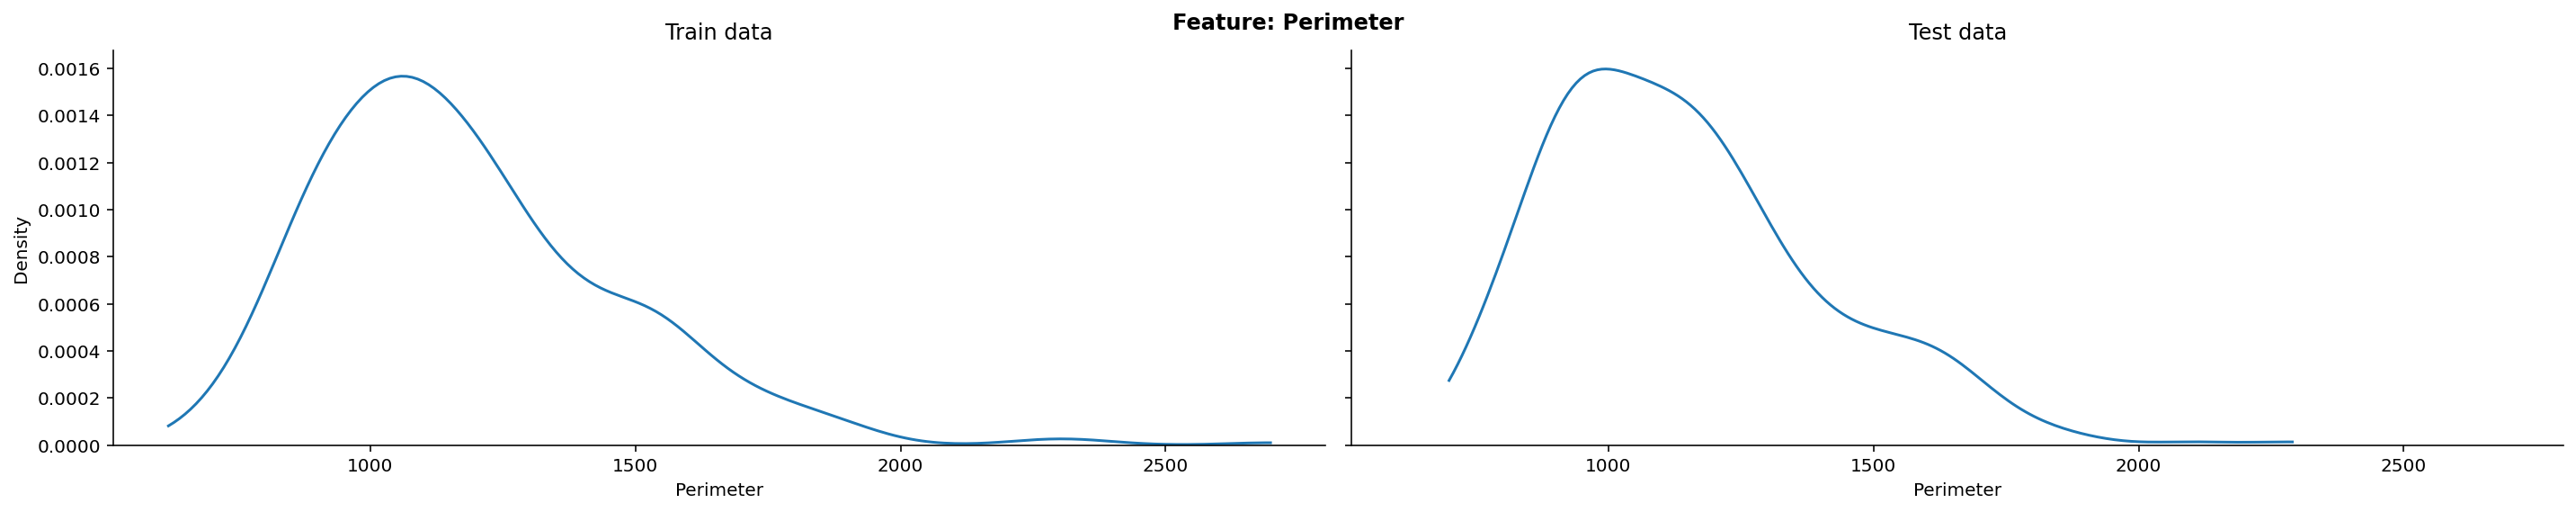

In [71]:
plot_cont('Perimeter')

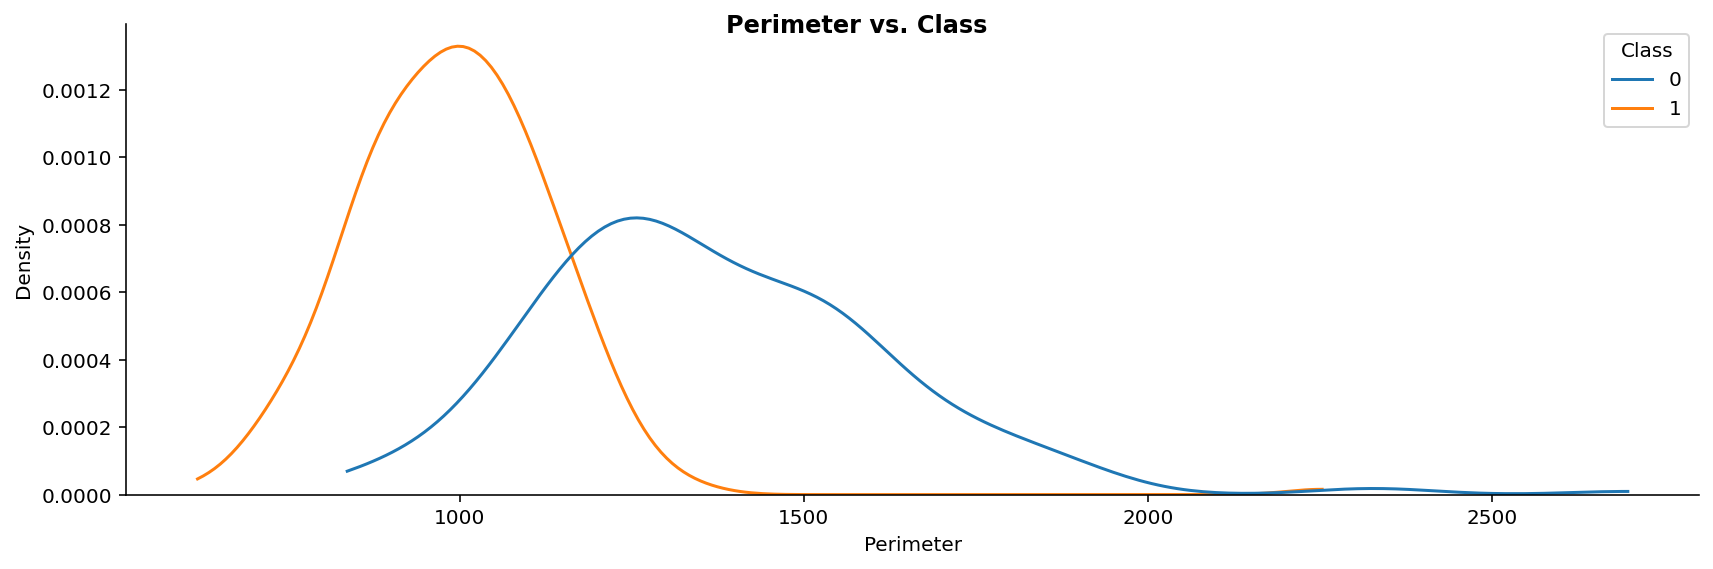

In [72]:
plot_cont_vs_target('Perimeter')

### MajorAxisLength

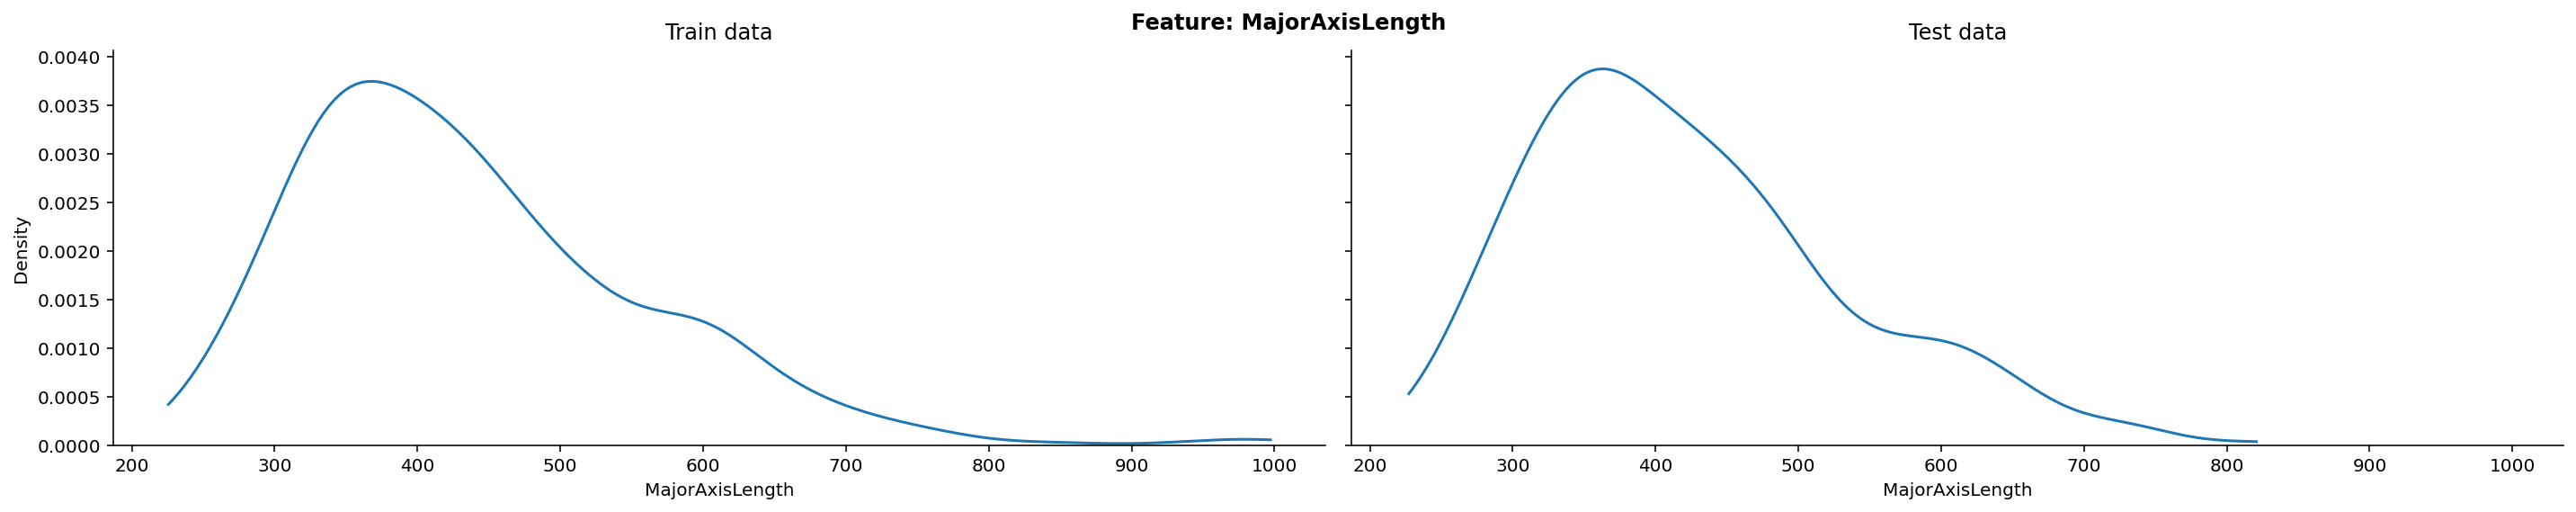

In [73]:
plot_cont('MajorAxisLength')

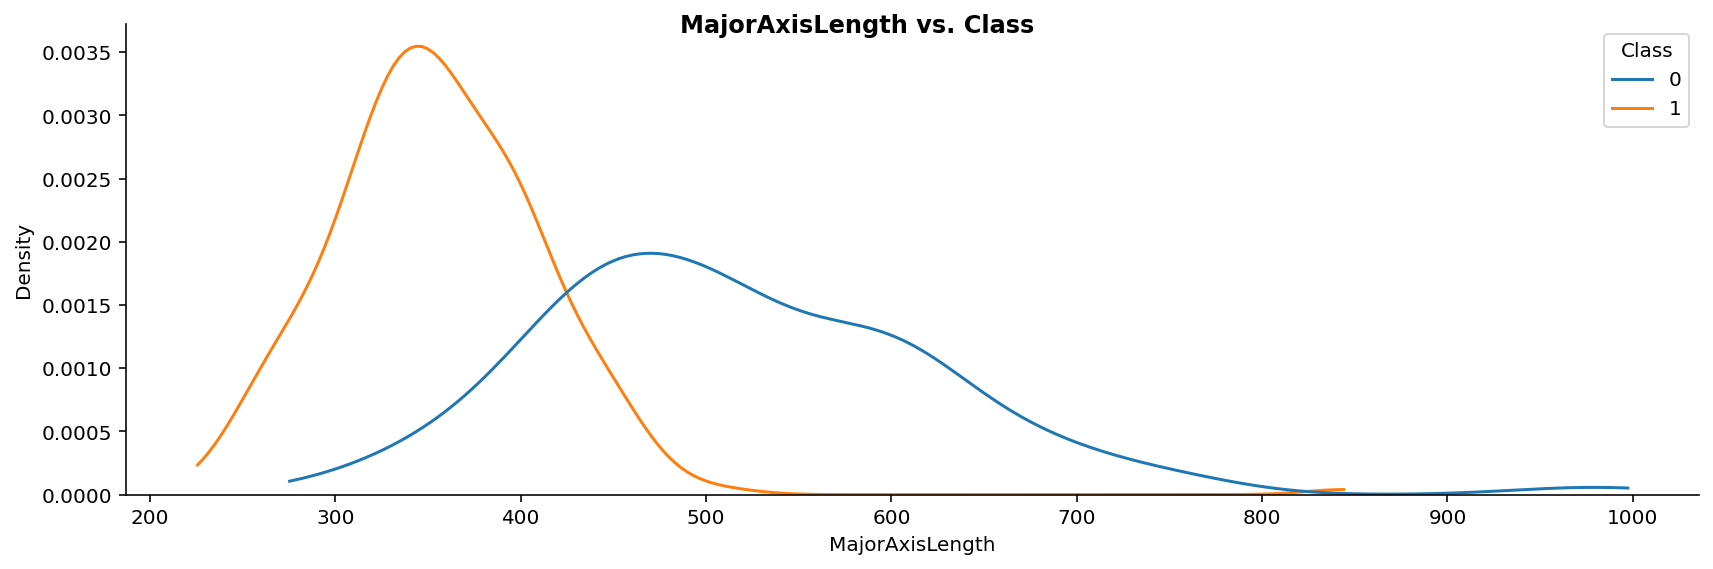

In [74]:
plot_cont_vs_target('MajorAxisLength')

### MinorAxisLength

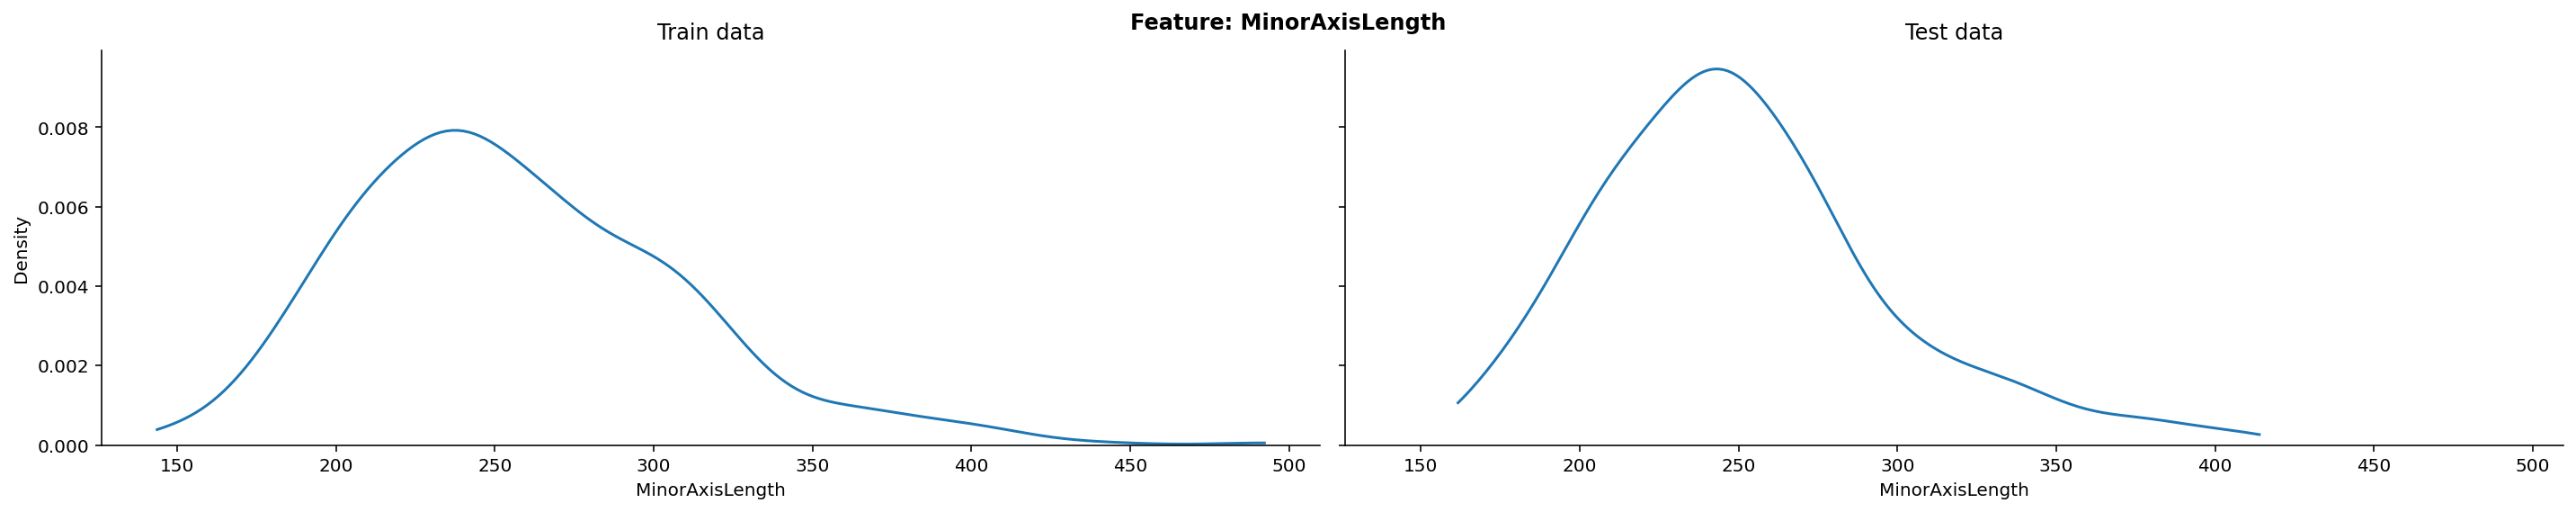

In [75]:
plot_cont('MinorAxisLength')

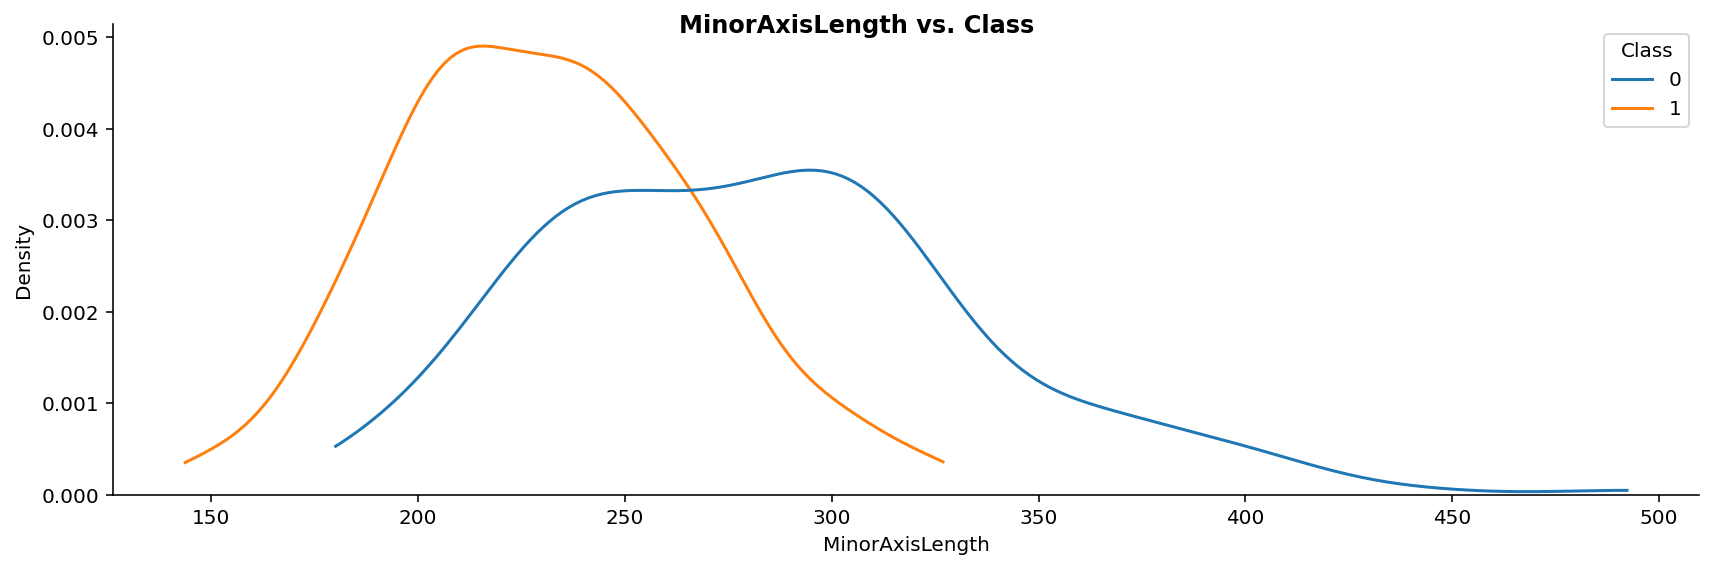

In [76]:
plot_cont_vs_target('MinorAxisLength')

### Eccentricity

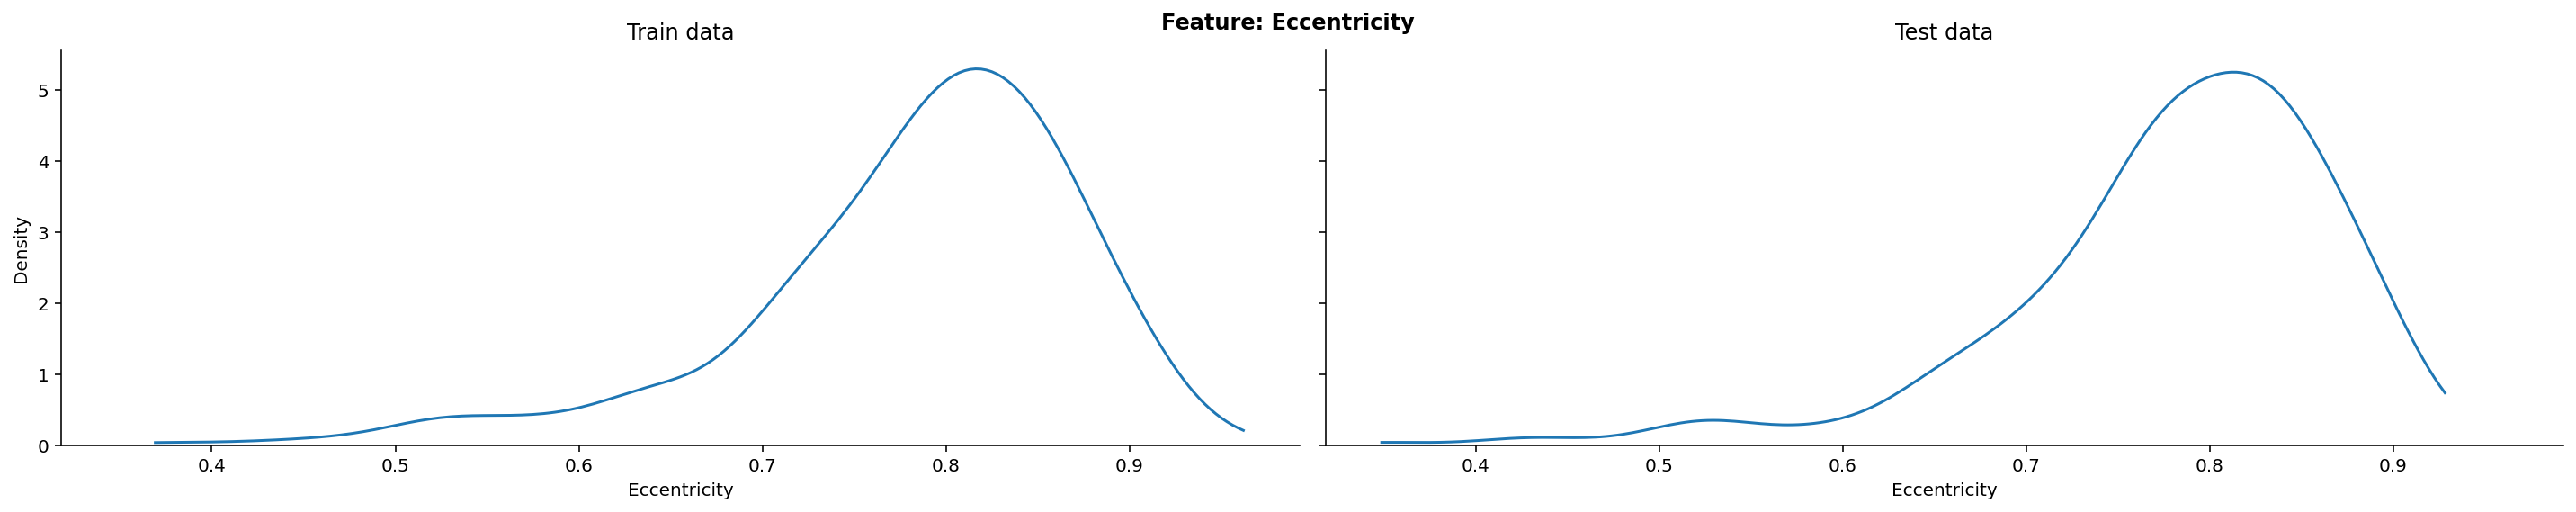

In [77]:
plot_cont('Eccentricity')

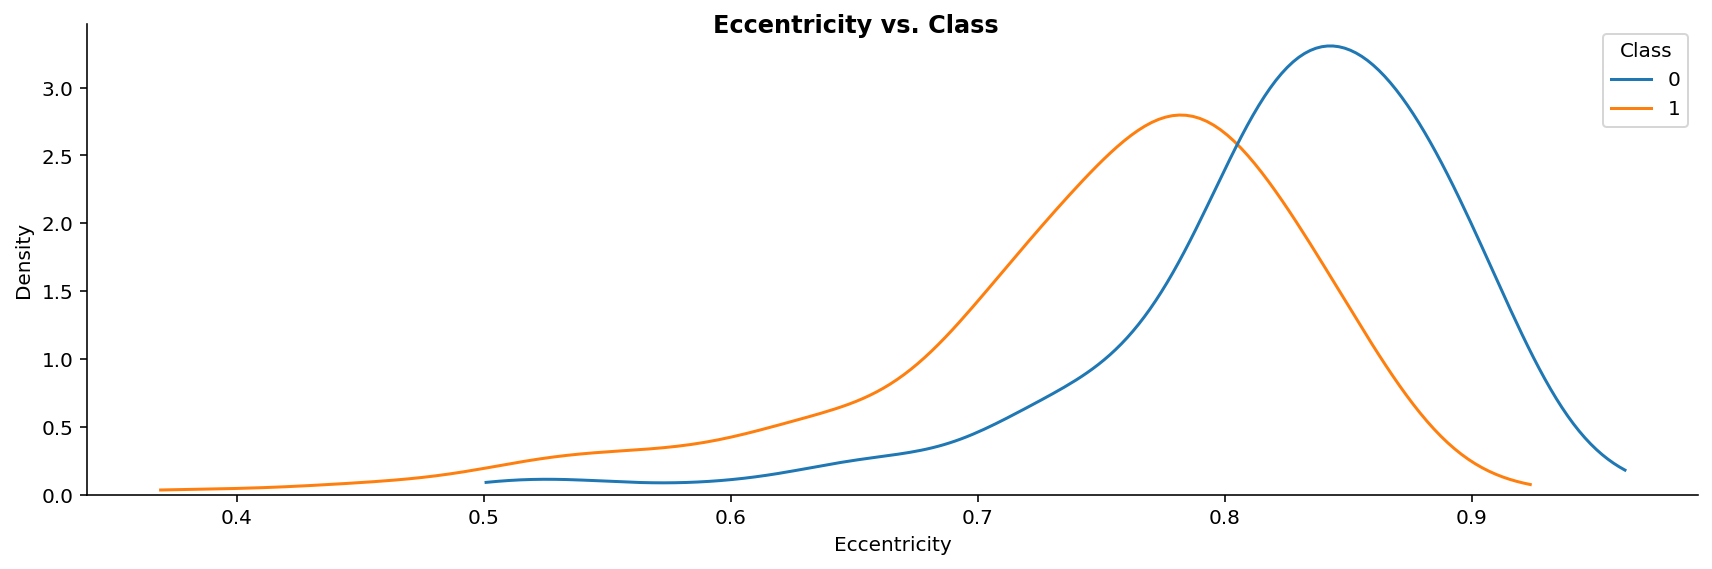

In [78]:
plot_cont_vs_target('Eccentricity')

### ConvexArea

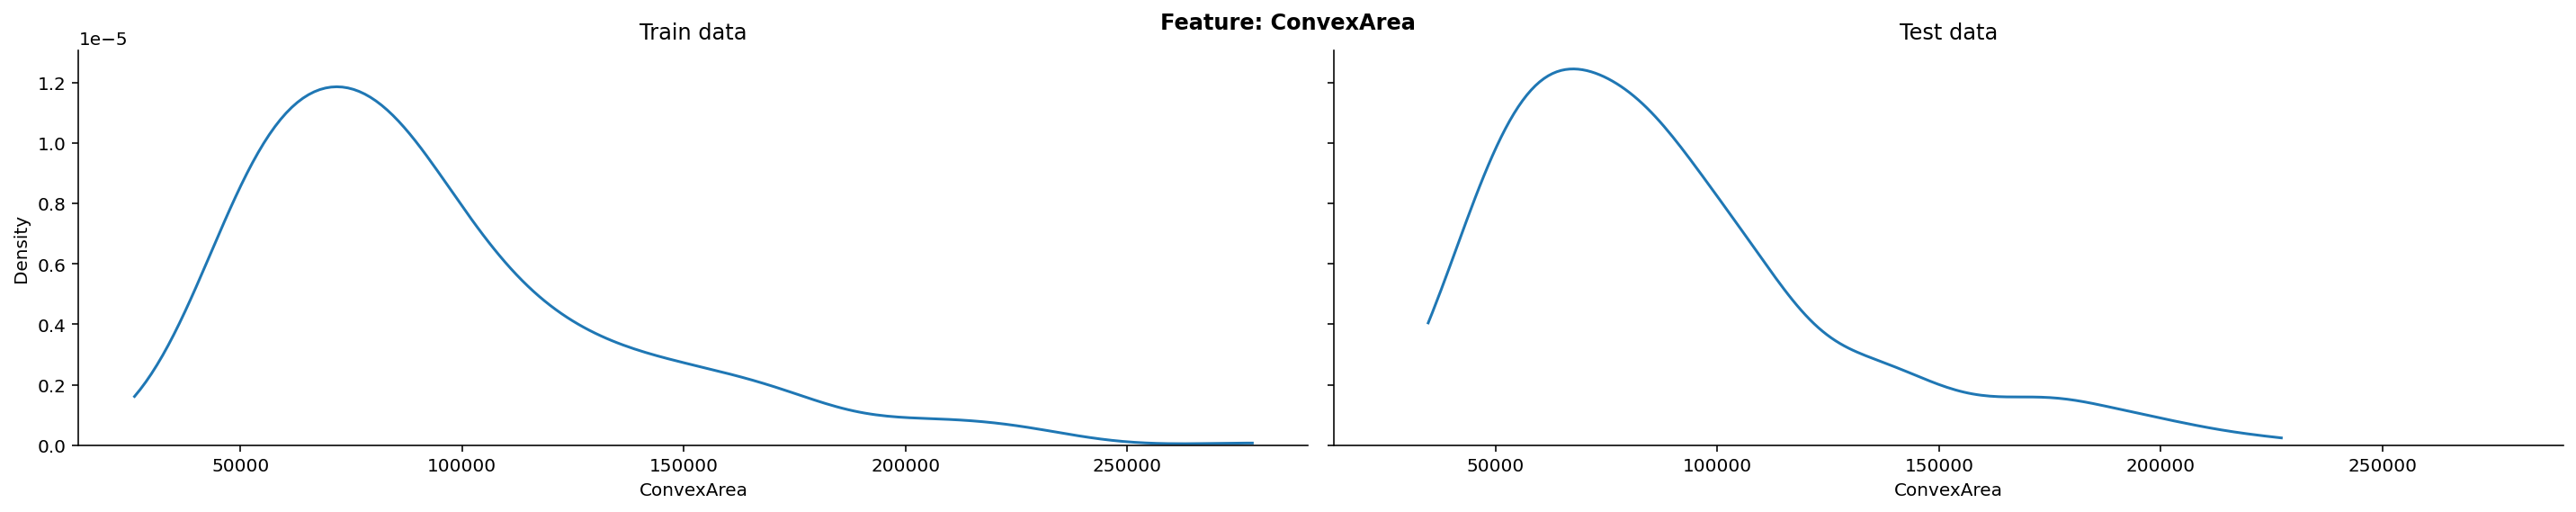

In [79]:
plot_cont('ConvexArea')

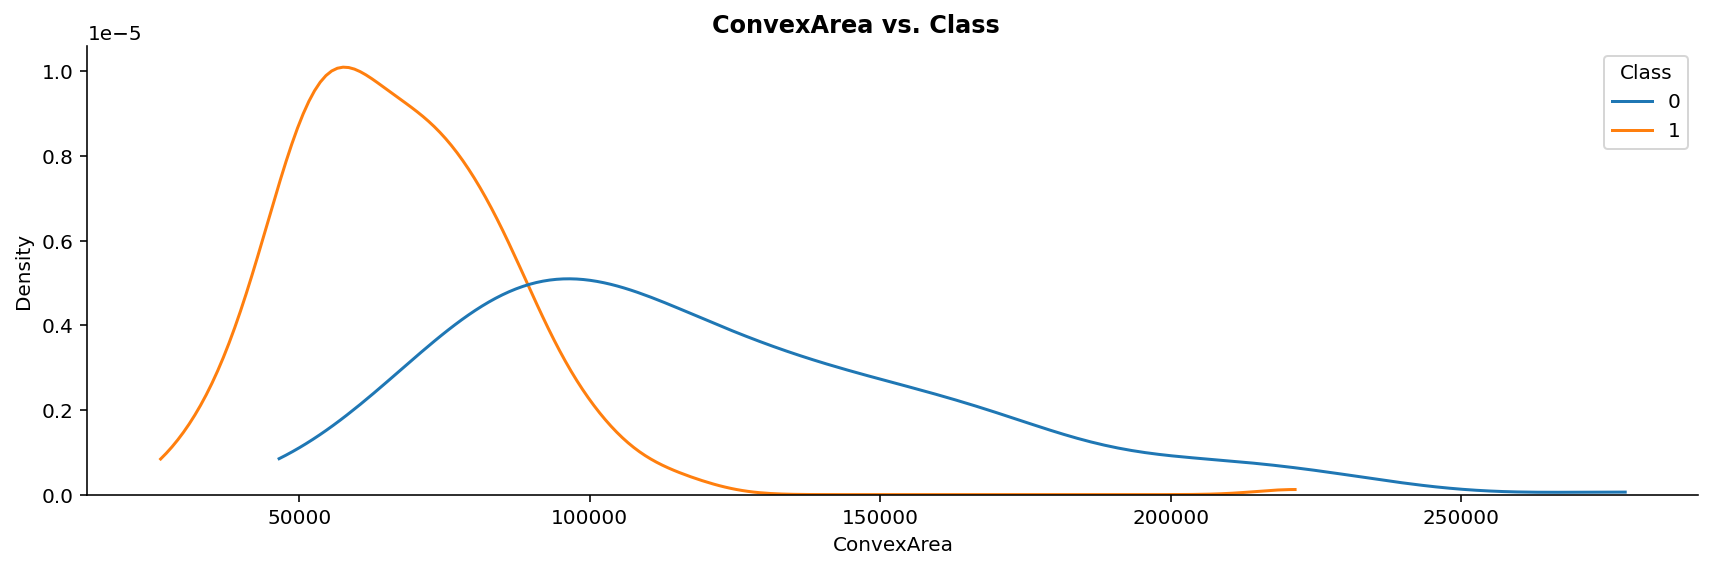

In [80]:
plot_cont_vs_target('ConvexArea')

### Extent

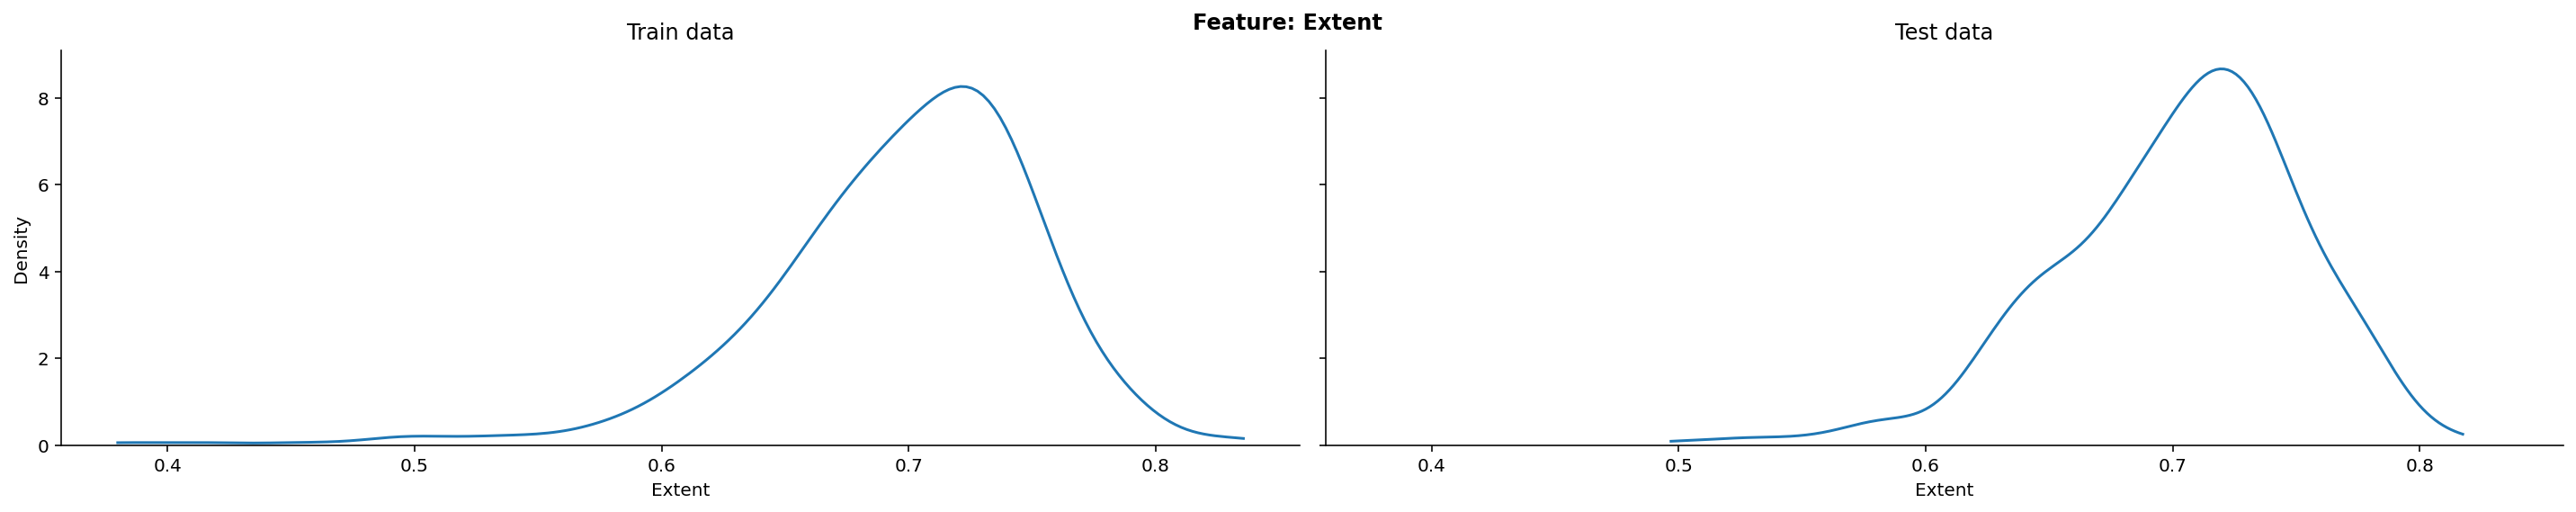

In [81]:
plot_cont('Extent')

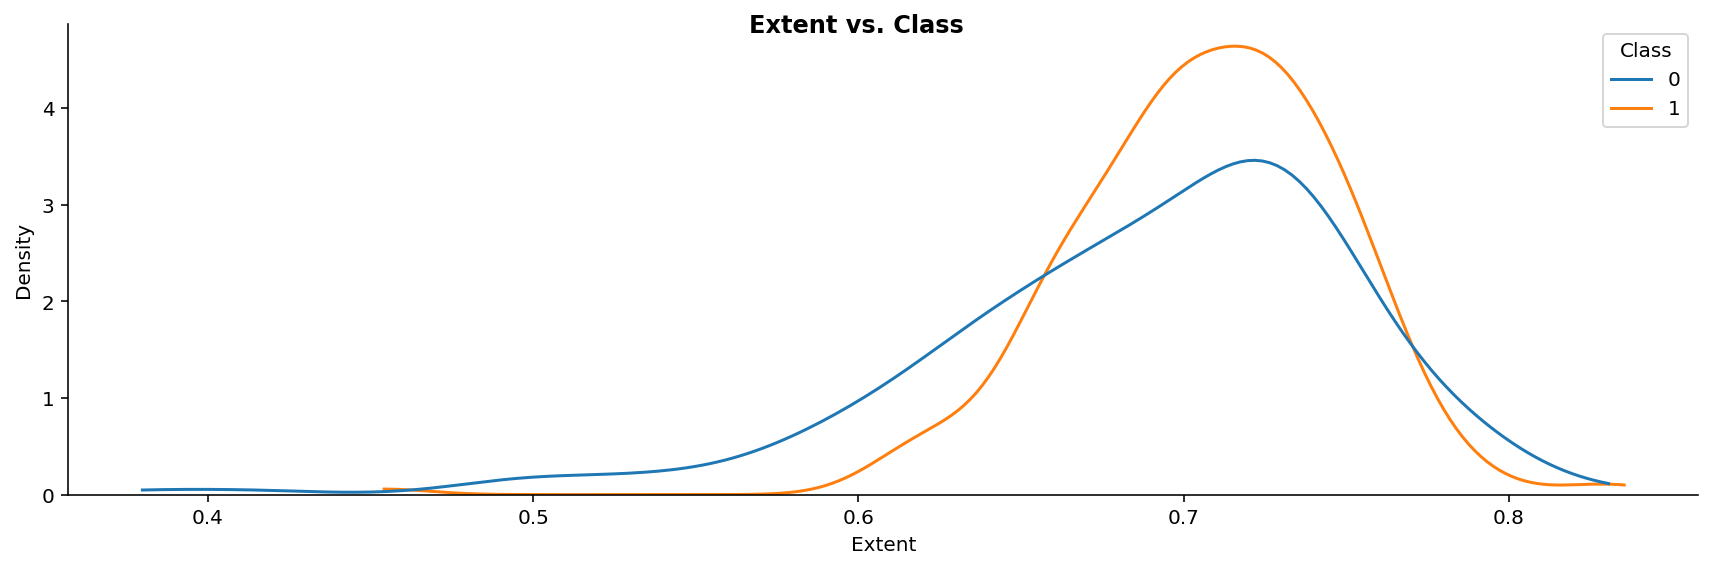

In [82]:
plot_cont_vs_target('Extent')

# Feature selection

### Pearson correlation

In [83]:
def plot_corr_matrix(corr_df):
    size = min(10, corr_df.shape[1])
    plt.figure(figsize=(size, size))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, 
                linewidths=0.1)
    plt.show()

In [84]:
corr_df = train[features + [TARGET]].corr()

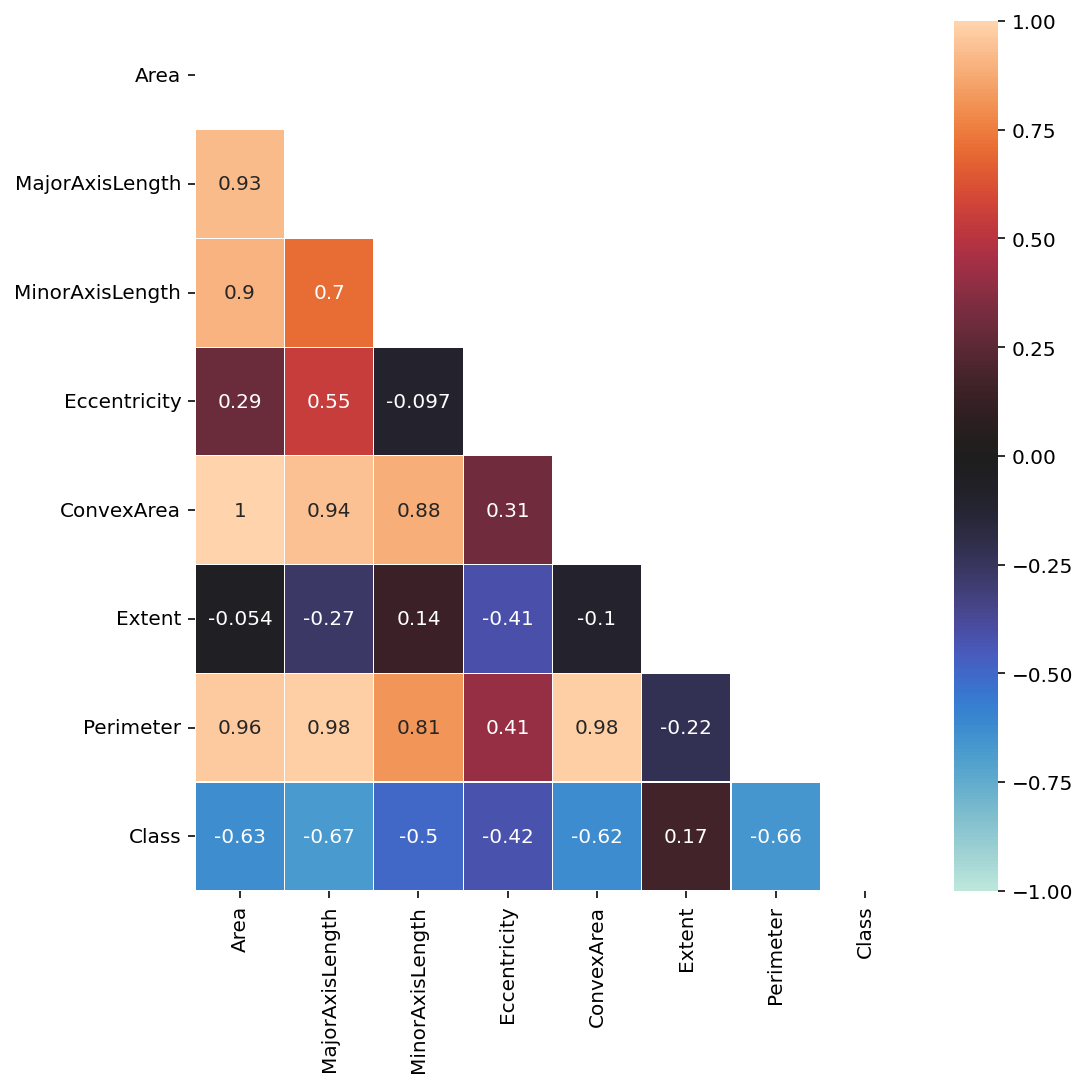

In [85]:
plot_corr_matrix(corr_df)

Several collinear features.

### Variance Inflation Factor

In [86]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [87]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))

    return list(X.columns)

In [88]:
_ = remove_vif_features(train[features], 10) #lenient threshold

Iteration 1: Perimeter            (3587.1324)
Iteration 2: ConvexArea           (1173.4638)
Iteration 3: MajorAxisLength      (316.3274)
Iteration 4: MinorAxisLength      (206.8600)
Iteration 5: Eccentricity         (41.9819)
  Feature    VIF
0    Area  5.653
1  Extent  5.653


### ANOVA F-test

In [89]:
anova_test = f_classif(train[features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=features
)

,f-statistic,p-value,accepted?
Area,318.1039,2.8616e-55,True
MajorAxisLength,407.1750,1.8693e-66,True
MinorAxisLength,161.0006,4.0158e-32,True
Eccentricity,104.0749,2.6683e-22,True
ConvexArea,315.5109,6.3164e-55,True
Extent,14.3611,1.6955e-04,True
Perimeter,387.4317,4.4846e-64,True


### Mutual Information score

In [90]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
mi_score,0.2843,0.3523,0.1458,0.1473,0.2998,0.0626,0.3464


### Feature sets

In [91]:
feature_sets = {
    'all': features,
    'vif': ['Area', 'Extent'],
    'mi': [f for f in features if f not in ('Extent', 'Eccentricity', 'MinorAxisLength')],
    'noncorr': ['MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Extent']
}

# Modeling

In [92]:
def evaluate_model(model, features, seed=SEED, verbose=True):
    oof_preds = {}  #out-of-fold predictions on train set
    test_preds = {} #predictions on test set for each fold
    scores_acc = [] #Accuracy scores on validation set

    X = train[features]
    y = train[TARGET]
    X_test = test[features]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_idx, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(X_test)

        score = accuracy_score(y_val, val_preds)
        scores_acc.append(score)
        if verbose:
            print(f'Fold #{fold}: {score:.5f}', end=' || ')
        
        _ = gc.collect()

    print(f'Avg = {np.mean(scores_acc):.5f} +/- {np.std(scores_acc):.5f}\n')
    
    oof_preds = pd.Series(oof_preds).sort_index()
    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mode'] = test_preds.mode(axis=1)[0].astype('int8')
    return oof_preds, test_preds

In [93]:
oof_preds = pd.DataFrame()

In [94]:
SUBMISSION_PATH = '/content/drive/MyDrive/data_science_competitions/others/techgig_datascience_raisin/submissions'

def create_submission_files(
        predictions_df,
        model_number, 
        feature_set,  
        path=SUBMISSION_PATH):
    
    file_path = f'{path}/m_{model_number}/{feature_set}'
    if not os.path.isdir(file_path):
        os.makedirs(file_path)

    for col in (predictions_df.columns):
        sub = pd.DataFrame({
            'Key': TEST_INDEX, 
            TARGET: label_enc.inverse_transform(predictions_df[col])
        })
        sub.to_csv(f'{file_path}/{col}.csv', index=False)

    sub = pd.DataFrame({
        'Key': TEST_INDEX, 
        TARGET: label_enc.inverse_transform(predictions_df['mode'])
    })
    sub.to_csv(f'{file_path}/mode.csv', index=False)

### Model 01

In [95]:
%%time
model_1 = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=SEED)
)

print('All features:')
oof_preds['01_all'], test_preds_1_all = evaluate_model(model_1, feature_sets['all'])

print('VIF features:')
oof_preds['01_vif'], test_preds_1_vif = evaluate_model(model_1, feature_sets['vif'])

print('MI features:')
oof_preds['01_mi'], test_preds_1_mi = evaluate_model(model_1, feature_sets['mi'])

print('Non-correlated features:')
oof_preds['01_noncorr'], test_preds_1_noncorr = evaluate_model(model_1, feature_sets['noncorr'])

All features:
Fold #0: 0.85859 || Fold #1: 0.89899 || Fold #2: 0.81818 || Fold #3: 0.86869 || Fold #4: 0.89899 || Avg = 0.86869 +/- 0.02996

VIF features:
Fold #0: 0.84848 || Fold #1: 0.84848 || Fold #2: 0.76768 || Fold #3: 0.84848 || Fold #4: 0.84848 || Avg = 0.83232 +/- 0.03232

MI features:
Fold #0: 0.84848 || Fold #1: 0.89899 || Fold #2: 0.81818 || Fold #3: 0.88889 || Fold #4: 0.88889 || Avg = 0.86869 +/- 0.03064

Non-correlated features:
Fold #0: 0.85859 || Fold #1: 0.87879 || Fold #2: 0.81818 || Fold #3: 0.88889 || Fold #4: 0.87879 || Avg = 0.86465 +/- 0.02523

CPU times: user 2.38 s, sys: 54.5 ms, total: 2.44 s
Wall time: 2.47 s


In [96]:
create_submission_files(test_preds_1_all, model_number='01', feature_set='all')
create_submission_files(test_preds_1_vif, model_number='01', feature_set='vif')
create_submission_files(test_preds_1_mi, model_number='01', feature_set='mi')
create_submission_files(test_preds_1_noncorr, model_number='01', feature_set='noncorr')

### Model 02

In [97]:
%%time
model_2 = RandomForestClassifier(random_state=SEED)

print('All features:')
oof_preds['02_all'], test_preds_2_all = evaluate_model(model_2, feature_sets['all'])

print('VIF features:')
oof_preds['02_vif'], test_preds_2_vif = evaluate_model(model_2, feature_sets['vif'])

print('MI features:')
oof_preds['02_mi'], test_preds_2_mi = evaluate_model(model_2, feature_sets['mi'])

print('Non-correlated features:')
oof_preds['02_noncorr'], test_preds_2_noncorr = evaluate_model(model_2, feature_sets['noncorr'])

All features:
Fold #0: 0.85859 || Fold #1: 0.89899 || Fold #2: 0.81818 || Fold #3: 0.86869 || Fold #4: 0.85859 || Avg = 0.86061 +/- 0.02587

VIF features:
Fold #0: 0.81818 || Fold #1: 0.84848 || Fold #2: 0.71717 || Fold #3: 0.85859 || Fold #4: 0.85859 || Avg = 0.82020 +/- 0.05360

MI features:
Fold #0: 0.84848 || Fold #1: 0.87879 || Fold #2: 0.80808 || Fold #3: 0.88889 || Fold #4: 0.87879 || Avg = 0.86061 +/- 0.02955

Non-correlated features:
Fold #0: 0.85859 || Fold #1: 0.86869 || Fold #2: 0.83838 || Fold #3: 0.89899 || Fold #4: 0.85859 || Avg = 0.86465 +/- 0.01979

CPU times: user 6.28 s, sys: 54.8 ms, total: 6.33 s
Wall time: 6.39 s


In [98]:
create_submission_files(test_preds_2_all, model_number='02', feature_set='all')
create_submission_files(test_preds_2_vif, model_number='02', feature_set='vif')
create_submission_files(test_preds_2_mi, model_number='02', feature_set='mi')
create_submission_files(test_preds_2_noncorr, model_number='02', feature_set='noncorr')

### Ensembling

**Top-3 cross-validation models**

In [99]:
top3_oof_preds = oof_preds[['01_all', '01_mi', '02_noncorr']].mode(axis=1)[0].astype('int8')

In [100]:
print(f'Top-3 OOF accuracy = {accuracy_score(train[TARGET], top3_oof_preds):.5f}')

Top-3 OOF accuracy = 0.87273


In [101]:
top3_test_preds = pd.concat(
    [
        test_preds_1_all['mode'],
        test_preds_1_mi['mode'],
        test_preds_2_noncorr['mode']
    ],
    axis=1
).mode(axis=1)[0].astype('int8')

In [106]:
top3_test_preds.value_counts(normalize=True)

1    0.5481
0    0.4519
Name: 0, dtype: float64

In [102]:
file_path = f'{SUBMISSION_PATH}/ensembles'
if not os.path.isdir(file_path):
    os.makedirs(file_path)

sub = pd.DataFrame({
    'Key': TEST_INDEX, 
    TARGET: label_enc.inverse_transform(top3_test_preds)
})
sub.to_csv(f'{file_path}/top3_cv_mode.csv', index=False)

**Merging best folds**

In [103]:
foldmerge_preds = pd.concat(
    [
     test_preds_2_all['fold0'],
     test_preds_1_mi['fold1'],
     test_preds_2_noncorr['fold2'], 
     test_preds_2_noncorr['fold3'],
     test_preds_1_all['fold4']
    ],
    axis=1
).mode(axis=1)[0].astype('int8')

In [107]:
foldmerge_preds.value_counts(normalize=True)

1    0.5531
0    0.4469
Name: 0, dtype: float64

In [104]:
sub = pd.DataFrame({
    'Key': TEST_INDEX, 
    TARGET: label_enc.inverse_transform(foldmerge_preds)
})
sub.to_csv(f'{file_path}/merge_best_folds.csv', index=False)